### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from os.path import join
from scipy.io.wavfile import write
import matplotlib.pyplot as plt

### File paths and columns

In [2]:
RECORDING_DIR = "recordings"
OUTPUT_DIR = "output_wav"
MECH_READINGS_FILE = "mechanica_october.TXT"
SOUND_READINGS_FILE = "nonMech_october.TXT"

In [3]:
mech_cols = ["date", "time", "ntipps", "rainfall (mm)"]
mech_cols_desired = ["datetime", "ntipps", "rainfall (mm)"]
sound_cols = ["date", "time", "sound", "loudness"]
sound_cols_desired = ["datetime", "sound", "loudness"]
col_names = ["raw_audio", "filtered_audio"]

### Read files

In [4]:
mech_file_path = join(RECORDING_DIR, MECH_READINGS_FILE)
mech_data = pd.read_csv(mech_file_path, names=mech_cols)

sound_file_path = join(RECORDING_DIR, SOUND_READINGS_FILE)
sound_data = pd.read_csv(sound_file_path, names=sound_cols)

In [5]:
mech_data

,date,time,ntipps,rainfall (mm)
0,2023/10/13,16:51,1,0.20 mm
1,2023/10/13,16:52,0,0.00 mm
2,2023/10/13,16:53,0,0.00 mm
3,2023/10/13,16:54,5,1.00 mm
4,2023/10/13,16:55,29,5.80 mm
...,...,...,...,...
1308,2023/10/14,14:39,0,0.00 mm
1309,2023/10/14,14:40,0,0.00 mm
1310,2023/10/14,14:41,0,0.00 mm
1311,2023/10/14,14:42,0,0.00 mm


In [6]:
cutoff_value = 0.0

### Clean data

In [7]:
def process_mech_data(df):
    df["datetime"] = df["date"]+" "+df["time"]
    df["datetime"] = pd.to_datetime(df["datetime"])
    df = df.drop(["date", "time"], axis=1)
    df = df[mech_cols_desired]
    df["rainfall (mm)"] = df["rainfall (mm)"].str.split(" ").str[1]
    df["rainfall (mm)"] = df["rainfall (mm)"].astype(float)
    df = df[df["rainfall (mm)"]>cutoff_value]
    return df

In [8]:
def process_sound_data(df):
    df["time"] = df["time"].str.split(":").str[:-1].str.join(":")
    df["date"] = df["date"].str.split("/").str[::-1].str.join("-")
    df["datetime"] = df["date"]+" "+df["time"]
    df["datetime"] = pd.to_datetime(df["datetime"])
    df = df.drop(["date", "time"], axis=1)
    df = df[sound_cols_desired]
    df["sound"] = df["sound"].astype(float)
    df["loudness"] = df["loudness"].astype(float)
    return df

In [9]:
mech_data = process_mech_data(mech_data)
sound_data = process_sound_data(sound_data)

### Filter matching points

In [10]:
timepoints = list(set(sound_data["datetime"]).intersection(mech_data["datetime"]))
sound_data = sound_data.loc[sound_data["datetime"].isin(timepoints)]
mech_data = mech_data.loc[mech_data["datetime"].isin(timepoints)]

### Merge data and compute time difference to last reading

In [11]:
data_merged = pd.merge(mech_data, sound_data, on="datetime", how="inner")

In [12]:
data_merged['timedelta'] = (data_merged["datetime"]-data_merged["datetime"].shift()).fillna(pd.Timedelta(0))

In [13]:
data_merged["timedelta_min"] = data_merged["timedelta"].dt.total_seconds().div(60).astype(int)

In [14]:
data_merged

,datetime,ntipps,rainfall (mm),sound,loudness,timedelta,timedelta_min
0,2023-10-13 17:00:00,1,0.2,177.0,51.0,0 days 00:00:00,0
1,2023-10-13 18:38:00,1,0.2,134.0,36.0,0 days 01:38:00,98
2,2023-10-13 18:55:00,1,0.2,131.0,48.0,0 days 00:17:00,17
3,2023-10-13 19:20:00,1,0.2,131.0,48.0,0 days 00:25:00,25
4,2023-10-13 19:43:00,8,1.6,125.0,52.0,0 days 00:23:00,23
5,2023-10-13 19:44:00,11,2.2,128.0,49.0,0 days 00:01:00,1
6,2023-10-13 19:45:00,6,1.2,127.0,52.0,0 days 00:01:00,1
7,2023-10-13 19:46:00,5,1.0,129.0,47.0,0 days 00:01:00,1
8,2023-10-13 19:47:00,6,1.2,183.0,48.0,0 days 00:01:00,1
9,2023-10-13 19:48:00,5,1.0,200.0,53.0,0 days 00:01:00,1


### Scatter plot

Text(0.5, 1.0, 'Rainfall vs. loudness scatter plot')

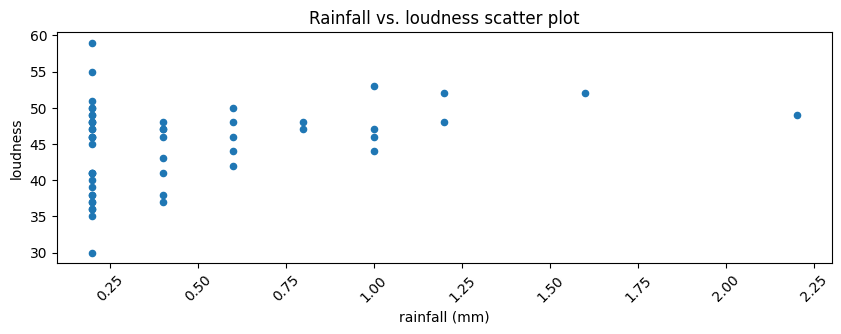

In [15]:
data_merged.plot(x="rainfall (mm)", y="loudness", kind='scatter', rot=45, figsize=(10,3))
plt.title("Rainfall vs. loudness scatter plot")

### Basic correlation analysis

#### Pearson Correlation

In [16]:
data_merged.corr(method='pearson')

,datetime,ntipps,rainfall (mm),sound,loudness,timedelta,timedelta_min
datetime,1.000000,-0.179288,-0.179288,-0.689430,-0.635272,0.406493,0.406493
ntipps,-0.179288,1.000000,1.000000,0.325563,0.321119,-0.141882,-0.141882
rainfall (mm),-0.179288,1.000000,1.000000,0.325563,0.321119,-0.141882,-0.141882
sound,-0.689430,0.325563,0.325563,1.000000,0.657560,-0.373070,-0.373070
loudness,-0.635272,0.321119,0.321119,0.657560,1.000000,-0.452599,-0.452599
timedelta,0.406493,-0.141882,-0.141882,-0.373070,-0.452599,1.000000,1.000000
timedelta_min,0.406493,-0.141882,-0.141882,-0.373070,-0.452599,1.000000,1.000000


#### Spearman Rank Correlation

In [17]:
data_merged.corr(method='spearman')

,datetime,ntipps,rainfall (mm),sound,loudness,timedelta,timedelta_min
datetime,1.000000,-0.226648,-0.226648,-0.617524,-0.705103,0.199567,0.199567
ntipps,-0.226648,1.000000,1.000000,0.450204,0.280484,-0.413006,-0.413006
rainfall (mm),-0.226648,1.000000,1.000000,0.450204,0.280484,-0.413006,-0.413006
sound,-0.617524,0.450204,0.450204,1.000000,0.563899,-0.534105,-0.534105
loudness,-0.705103,0.280484,0.280484,0.563899,1.000000,-0.349999,-0.349999
timedelta,0.199567,-0.413006,-0.413006,-0.534105,-0.349999,1.000000,1.000000
timedelta_min,0.199567,-0.413006,-0.413006,-0.534105,-0.349999,1.000000,1.000000


### Rainfall vs. Time to Previous Reading Plot

<Axes: xlabel='rainfall (mm)', ylabel='timedelta_min'>

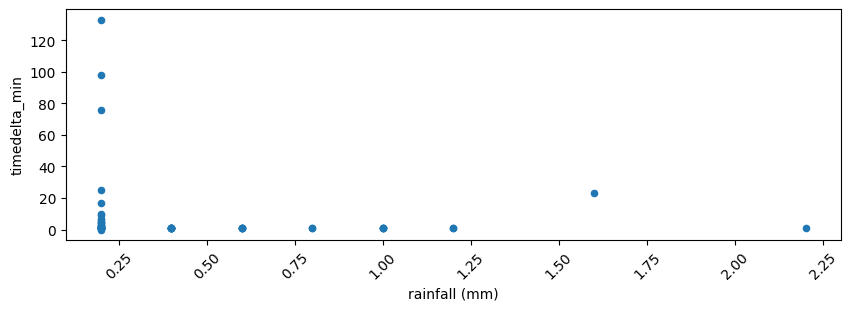

In [18]:
data_merged.plot(x="rainfall (mm)", y="timedelta_min", kind='scatter', rot=45, figsize=(10,3))

### Remove drizzling long rain

In [19]:
data_merged = data_merged[data_merged["rainfall (mm)"]>0.28]

In [20]:
data_merged.shape

(23, 7)

<Axes: xlabel='rainfall (mm)', ylabel='loudness'>

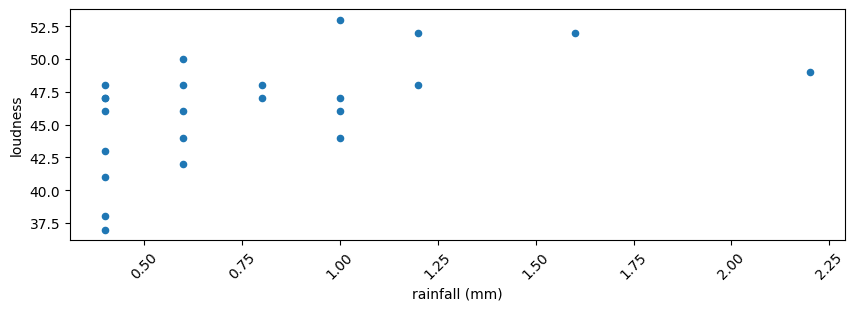

In [21]:
data_merged.plot(x="rainfall (mm)", y="loudness", kind='scatter', rot=45, figsize=(10,3))

<Axes: xlabel='rainfall (mm)', ylabel='sound'>

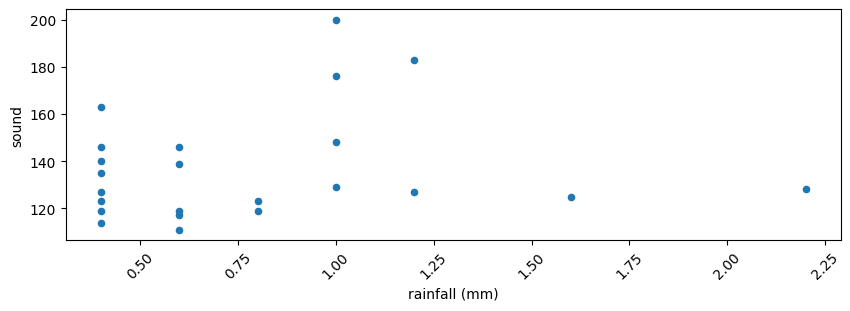

In [22]:
data_merged.plot(x="rainfall (mm)", y="sound", kind='scatter', rot=45, figsize=(10,3))

### Redo correlation analysis

In [23]:
data_merged.corr(method='pearson')

,datetime,ntipps,rainfall (mm),sound,loudness,timedelta,timedelta_min
datetime,1.000000,-0.609473,-0.609473,-0.408579,-0.658081,-0.274416,-0.274416
ntipps,-0.609473,1.000000,1.000000,0.151651,0.534764,0.391680,0.391680
rainfall (mm),-0.609473,1.000000,1.000000,0.151651,0.534764,0.391680,0.391680
sound,-0.408579,0.151651,0.151651,1.000000,0.359078,-0.114259,-0.114259
loudness,-0.658081,0.534764,0.534764,0.359078,1.000000,0.308251,0.308251
timedelta,-0.274416,0.391680,0.391680,-0.114259,0.308251,1.000000,1.000000
timedelta_min,-0.274416,0.391680,0.391680,-0.114259,0.308251,1.000000,1.000000


In [24]:
data_merged.corr(method='spearman')

,datetime,ntipps,rainfall (mm),sound,loudness,timedelta,timedelta_min
datetime,1.000000,-0.762285,-0.762285,-0.295472,-0.656404,-0.353553,-0.353553
ntipps,-0.762285,1.000000,1.000000,0.216389,0.596933,0.331038,0.331038
rainfall (mm),-0.762285,1.000000,1.000000,0.216389,0.596933,0.331038,0.331038
sound,-0.295472,0.216389,0.216389,1.000000,0.358161,-0.096591,-0.096591
loudness,-0.656404,0.596933,0.596933,0.358161,1.000000,0.307322,0.307322
timedelta,-0.353553,0.331038,0.331038,-0.096591,0.307322,1.000000,1.000000
timedelta_min,-0.353553,0.331038,0.331038,-0.096591,0.307322,1.000000,1.000000


### Observations

1. There is correlation w.r.t. mechanical readings and acoustic measurements
2. The acoustic feature loudness (pearson: 0.7371) is found to be more correlated to mechanical measurements
3. For low volumes of rain (0.28 mm), the variation in loudness is not very useful. Hence in these cases a different strategy needs to be deviced
4. For low volumes of rain (e.g. <=0.28 mm) the tipping event happens relatively after longer duration (10-150 min). Hence loudness measurement in the last minute may not account for the drizzling rain happened during that period.